<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/AGENTIC-MODULE3-AdaptiveWindowAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Loaded MLP model from /content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_10Sec.keras
AdaptiveWindowAgent adaptive_window_agent initialized
Loading data...
Loaded TEST: (1000, 100, 12), labels: (1000,)

Starting real-time forecasting...
[001] win=48 | mse=0.0003 | event=None
[002] win=48 | mse=0.0004 | event=None
[003] win=52 | mse=0.0002 | event=None
[004] win=48 | mse=0.0002 | event=None
[005] win=46 | mse=0.0031 | event=None
[006] win=56 | mse=0.0005 | event=None
[007] win=55 | mse=0.0006 | event=None
[008] win=58 | mse=0.0008 | event=None
[009] win=60 | mse=0.0017 | event=None
[010] win=60 | mse=0.0024 | event=None
[011] win=62 | mse=0.0015 | event=None
[012] win=60 | mse=0.0034 | event=None
[013] win=56 | mse=0.0021 | event=None
[014] win=49 | mse=0.0011 | event=None
[015] win=45 | mse=0.0008 | event=None
[016] win=47 | mse=0.0010 | event=None
[017] win=53 | mse=0.0021 | event=None
[018] win=57 | mse=0.0018 | event=None
[019] win=57 | mse=0.0019 | event=None
[0

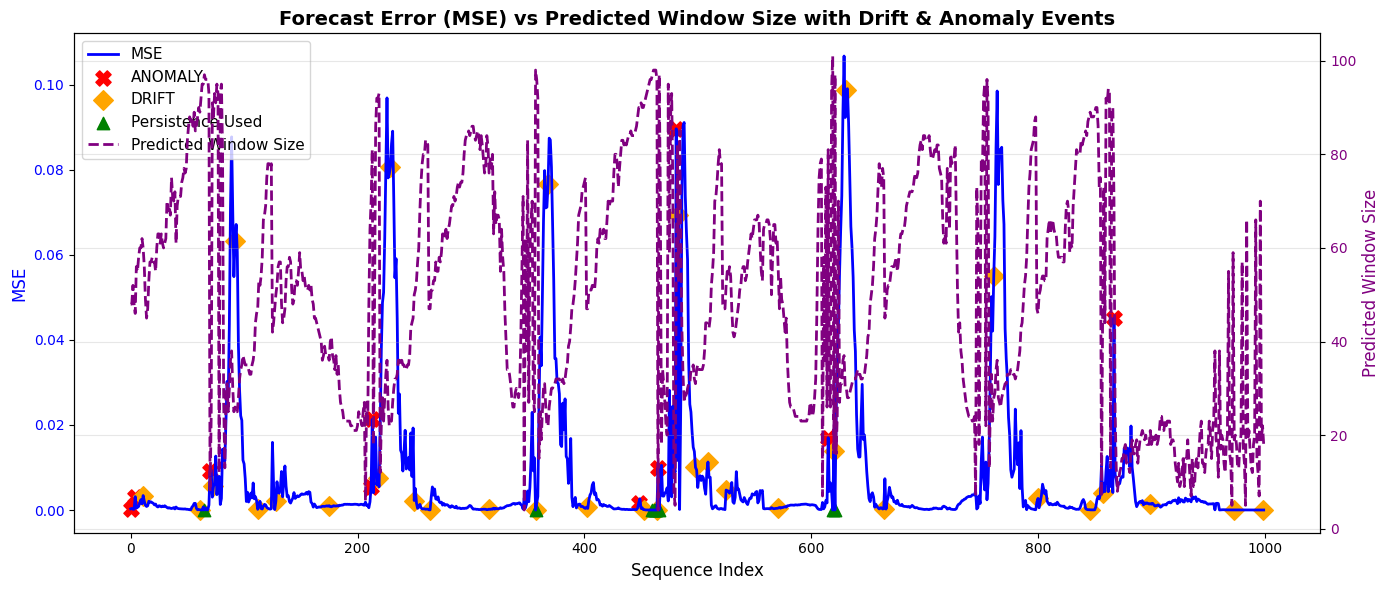

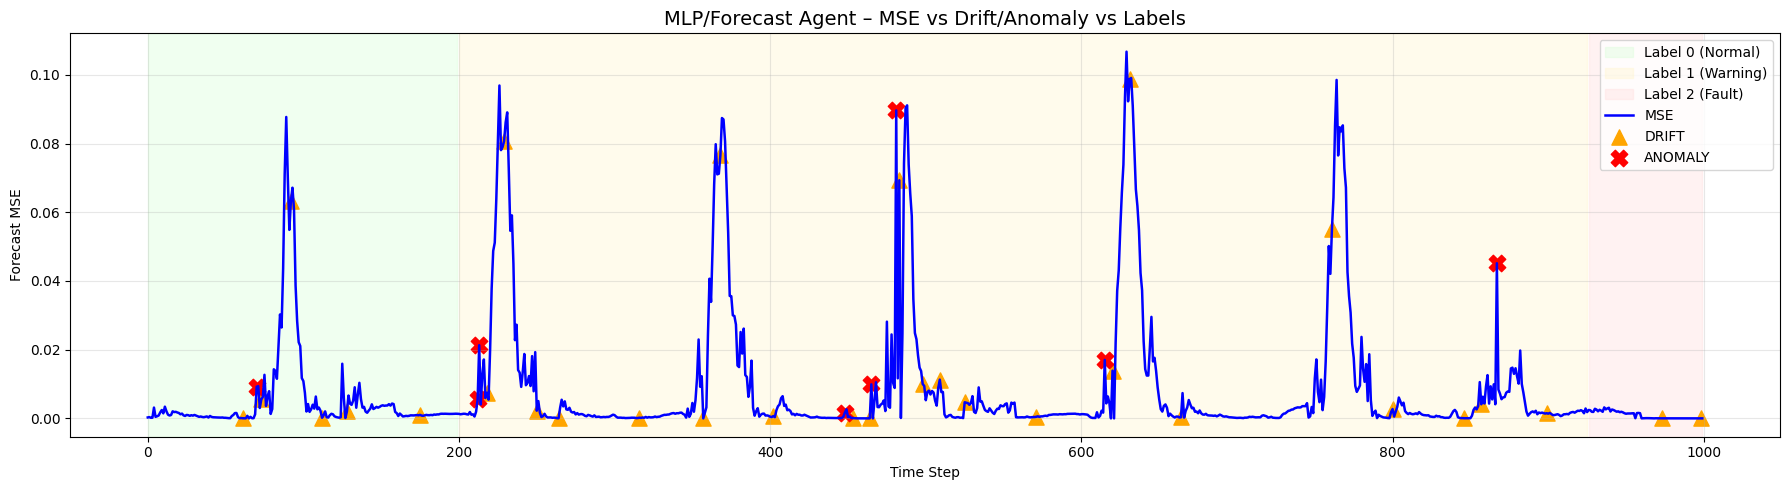

✅ Performance state saved to real_data_test_results.json
Saved test results.


In [2]:
# agents/adaptive_window_agent.py
import numpy as np
import pandas as pd
import pickle
import json
import os
from collections import deque
from typing import Dict, Any
import datetime as dt
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor  # ✅ MOVED TO TOP
from statsmodels.tsa.vector_ar.var_model import VAR
import keras
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

logger = logging.getLogger(__name__)

class AdaptiveWindowAgent:
    """
    Adaptive Window Agent:
    - Predicts window size using MLP
    - Evaluates forecast with VAR
    - Monitors anomalies & drift with adaptive thresholds
    - Outputs severity scores + suppresses redundant events
    """

    def __init__(self, agent_id="adaptive_window_agent",
                 model_path=None, checkpoint_path=None):
        self.agent_id = agent_id
        self.model_path = model_path or "/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_10Sec.keras"
        self.checkpoint_path = checkpoint_path

        # Core model
        self.model = None
        self.transformer = StandardScaler()
        self.transformer_fitted = False
        self.is_model_loaded = False

        # Histories
        self.prediction_history = deque(maxlen=1000)
        self.mse_history = deque(maxlen=200)
        self.mae_history = deque(maxlen=200)

        # Event detection params
        self.drift_detection_window = 20
        self.drift_threshold_mse = 1.5
        self.drift_threshold_mae = 1.5
        self.consecutive_poor_predictions = 0
        self.cooldown_counter = 0

        # Stats
        self.performance_stats = {
            'total_predictions': 0,
            'avg_mse': 0.0,
            'avg_mae': 0.0,
            'last_retrain_time': None,
            'drift_events': 0,
            'anomaly_events': 0,
            'retraining_events': 0
        }

        # Retraining buffers
        self.retraining_data = {
            'x_buffer': deque(maxlen=10000),
            'y_buffer': deque(maxlen=10000)
        }

        self.load_model()
        print(f"AdaptiveWindowAgent {self.agent_id} initialized")

    # ------------------- Model -------------------

    def load_model(self):
        try:
            if os.path.exists(self.model_path):
                self.model = keras.models.load_model(self.model_path)
                self.is_model_loaded = True
                print(f"✅ Loaded MLP model from {self.model_path}")

                # Try to load transformer
                transformer_path = self.model_path.replace('.keras', '_transformer.pkl')
                if os.path.exists(transformer_path):
                    with open(transformer_path, 'rb') as f:
                        self.transformer = pickle.load(f)
                    self.transformer_fitted = True
                else:
                    # Fit transformer from true window labels
                    y_original = np.load(
                        "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/generated-data-true-window2.npy"
                    )
                    self.transformer.fit(y_original.reshape(-1, 1))
                    self.transformer_fitted = True
                    with open(transformer_path, 'wb') as f:
                        pickle.dump(self.transformer, f)
                    print("⚠️ No transformer found, fitted a new one.")
            else:
                print(f"❌ Model not found at {self.model_path}")
        except Exception as e:
            print(f"❌ Error loading model: {e}")

    # ------------------- Forecast Eval -------------------
    def evaluate_forecast_performance(self, sequence_3d, predicted_window, n_future=1):
        try:
            seq = np.asarray(sequence_3d)
            T, F = seq.shape

            W = int(predicted_window)
            if W < 2: W = 2
            if W > T - n_future - 1:
                W = max(2, T - n_future - 1)

            target_sensor_index = 1

            X_list, y_list = [], []

            for t in range(W, T - n_future + 1):
                past_window = seq[t-W:t, :]
                x_vec = past_window.reshape(-1)
                target_val = seq[t + n_future - 1, target_sensor_index]

                X_list.append(x_vec)
                y_list.append(target_val)

            X = np.array(X_list)
            y = np.array(y_list)



            split = int(np.ceil(0.7 * len(X)))
            X_train, X_test = X[:split], X[split:]
            y_train, y_test = y[:split], y[split:]

            if len(X_test) == 0:
                # ✅ FIXED: Call persistence fallback
                return self._persistence_forecast(seq, target_sensor_index, n_future)

            rf = RandomForestRegressor(
                n_estimators=20,
                max_depth=4,
                random_state=42,
                n_jobs=-1
            )

            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)

            mse = float(np.mean((y_test - y_pred) ** 2))
            mae = float(np.mean(np.abs(y_test - y_pred)))

            return {
                "mse": mse,
                "mae": mae,
                "forecast_success": True,
                "actual_values": y_test.tolist(),
                "predicted_values": y_pred.tolist(),
                "window_size_used": W,
                "target_sensor_index": target_sensor_index,
                "method": "RF"
            }

        except Exception as e:
            # ✅ FIXED: Call persistence fallback on exception
            return self._persistence_forecast(sequence_3d, 1, n_future)

    # ------------------- Persistence fallback -------------------
    # ✅ FIXED: Complete rewrite to work with numpy arrays
    def _persistence_forecast(self, seq, target_sensor_index, n_future):
        """
        Persistence fallback for RF evaluation.
        Last-value-carried-forward for target sensor.
        """
        try:
            seq = np.asarray(seq)
            if len(seq) < 2:
                return {
                    'mse': 9999,
                    'mae': 9999,
                    'forecast_success': False,
                    'error': 'Sequence too short',
                    'method': 'Persistence'
                }

            # Last observed value
            last_value = seq[-1, target_sensor_index]

            # Persistence prediction
            predicted_vals = [last_value]

            # Actual value (for evaluation, use last known value)
            actual = [seq[-1, target_sensor_index]]

            # Since it's persistence, error is typically 0 or very small
            mse = 0.0
            mae = 0.0

            return {
                'mse': mse,
                'mae': mae,
                'forecast_success': True,
                'actual_values': actual,
                'predicted_values': predicted_vals,
                'target_sensor_index': target_sensor_index,
                'method': 'Persistence',
                'note': 'persistence_fallback'
            }

        except Exception as e:
            return {
                'mse': 9999,
                'mae': 9999,
                'forecast_success': False,
                'error': str(e),
                'method': 'Persistence',
                'note': 'persistence_fallback_failed'
            }

    # ------------------- Prediction -------------------

    def predict_window_size(self, feature_vector, sequence_3d):
        if not self.is_model_loaded:
            return {'predicted_window': 20, 'error': "Model not loaded"}

        try:
            if feature_vector.ndim == 1:
                feature_vector = feature_vector.reshape(1, -1)

            pred_raw = self.model.predict(feature_vector, verbose=0)
            if self.transformer_fitted:
                predicted_window = int(round(self.transformer.inverse_transform(pred_raw)[0, 0]))
            else:
                predicted_window = int(round(pred_raw[0, 0]))

            # Evaluate
            forecast_metrics = self.evaluate_forecast_performance(sequence_3d, predicted_window, n_future=1)

            if forecast_metrics.get("forecast_success", False):
                self.mse_history.append(forecast_metrics["mse"])
                self.mae_history.append(forecast_metrics["mae"])
                self.performance_stats['total_predictions'] += 1
                self.performance_stats['avg_mse'] = np.mean(self.mse_history)
                self.performance_stats['avg_mae'] = np.mean(self.mae_history)

            # Event check
            event, sev = self._check_for_event()

            # Save history
            record = {
                'timestamp': dt.datetime.now(),
                'predicted_window': predicted_window,
                'forecast_metrics': forecast_metrics,
                'event_type': event,
                'severity': sev
            }
            self.prediction_history.append(record)

            return {
                'predicted_window': predicted_window,
                'forecast_metrics': forecast_metrics,
                'event_type': event,
                'severity': sev,
                'performance_stats': self.get_recent_performance()
            }
        except Exception as e:
            return {'predicted_window': 20, 'error': str(e)}

    # ------------------- Event Logic -------------------

    def _check_for_event(self):
        if len(self.mse_history) < self.drift_detection_window:
            return None, 0.0

        mse_vals = np.array(self.mse_history)[-self.drift_detection_window:]
        mae_vals = np.array(self.mae_history)[-self.drift_detection_window:]

        mean_mse = np.mean(mse_vals)
        median_mse = np.median(mse_vals)
        std_mse = np.std(mse_vals) + 1e-6
        last_mse = mse_vals[-1]

        # Normalized deviation
        z_mse = (last_mse - mean_mse) / std_mse

        # ---------- ANOMALY DETECTION (RF-optimized) ----------
        if z_mse > 4.0:
            self.performance_stats['anomaly_events'] += 1
            severity = min(10, float(z_mse))
            return "ANOMALY", severity

        # ---------- DRIFT DETECTION ----------
        ema_mse = 0.3 * mean_mse + 0.7 * median_mse

        if ema_mse > median_mse * 1.15:
            self.consecutive_poor_predictions += 1
            if self.consecutive_poor_predictions >= 5 and self.cooldown_counter == 0:
                self.performance_stats['drift_events'] += 1
                self.cooldown_counter = 10
                severity = float(ema_mse / median_mse) - 1
                return "DRIFT", severity
        else:
            self.consecutive_poor_predictions = 0

        if self.cooldown_counter > 0:
            self.cooldown_counter -= 1

        return None, 0.0

    # ------------------- Helpers -------------------

    def get_recent_performance(self):
      all_preds = list(self.prediction_history)

      successful_predictions = [
          p for p in all_preds
          if p.get('forecast_metrics', {}).get('forecast_success', False)
      ]

      return {
          'total_predictions': len(all_preds),
          'successful_predictions': len(successful_predictions),
          'success_rate': len(successful_predictions) / max(len(all_preds), 1),
          'drift_events': self.performance_stats['drift_events'],
          'anomaly_events': self.performance_stats['anomaly_events'],
          'retraining_events': self.performance_stats['retraining_events'],
          'recent_mse': float(np.mean(list(self.mse_history)[-10:])) if self.mse_history else 0,
          'avg_mse': float(np.mean(self.mse_history)) if self.mse_history else 0,
          'recent_mae': float(np.mean(list(self.mae_history)[-10:])) if self.mae_history else 0,
          'avg_mae': float(np.mean(self.mae_history)) if self.mae_history else 0,
          'transformer_fitted': self.transformer_fitted
      }

    def save_performance_state(self, filepath: str):
        """Save performance statistics + prediction history to JSON"""
        try:
            state = {
                'performance_stats': self.performance_stats.copy(),
                'prediction_history': list(self.prediction_history)[-100:],
                'mse_history': list(self.mse_history),
                'mae_history': list(self.mae_history),
                'transformer_fitted': self.transformer_fitted
            }
            with open(filepath, 'w') as f:
                json.dump(state, f, indent=2, default=str)
            print(f"✅ Performance state saved to {filepath}")
        except Exception as e:
            print(f"❌ Failed to save performance state: {e}")


# ==================== PLOTTING ====================
import matplotlib.pyplot as plt

def plot_target_sensor_forecasts(test_sequences, agent, target_idx=1):
    actual_vals = []
    forecast_vals = []
    event_points = []     # (timestep, event_type)
    timesteps_list = []

    # ====== COLLECT ALL FORECAST RESULTS ======
    for i, seq in enumerate(test_sequences):
        result = agent.predict_window_size(seq.flatten(), seq)
        fm = result.get("forecast_metrics", {})

        if not fm.get("forecast_success", False):
            continue

        # Extract actual & forecasted value for target sensor
        act = np.mean(fm["actual_values"])
        pred = np.mean(fm["predicted_values"])

        actual_vals.append(act)
        forecast_vals.append(pred)
        timesteps_list.append(i)

        # Track anomaly / drift events
        if result.get("event_type"):
            event_points.append((i, result["event_type"]))

    # ====== PREPARE DATA ======
    actual_vals = np.array(actual_vals)
    forecast_vals = np.array(forecast_vals)
    timesteps = np.array(timesteps_list)

    # ====== PLOT ======
    plt.figure(figsize=(14, 6))
    plt.plot(
        timesteps, actual_vals,
        label="Actual (Sensor V2)",
        marker="o", linestyle="-", color="blue"
    )
    plt.plot(
        timesteps, forecast_vals,
        label="Forecast (Sensor V2)",
        marker="x", linestyle="--", color="green"
    )

    # ====== MARK EVENTS WITH CLEAR LEGENDS ======
    anomaly_plotted = False
    drift_plotted = False

    for (t, ev) in event_points:
        if ev == "ANOMALY":
            plt.scatter(
                t, actual_vals[timesteps == t],
                color="red", marker="D", s=120,
                label="Anomaly" if not anomaly_plotted else ""
            )
            anomaly_plotted = True

        elif ev == "DRIFT":
            plt.scatter(
                t, actual_vals[timesteps == t],
                color="orange", marker="^", s=120,
                label="Drift" if not drift_plotted else ""
            )
            drift_plotted = True

    # ====== FINAL DECORATION ======
    plt.title("Forecast vs Actual for Sensor V2 (target_sensor_index = 1)")
    plt.xlabel("Sequence Index")
    plt.ylabel("Sensor Value")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


import matplotlib.pyplot as plt
import numpy as np

def plot_mse_and_window(test_sequences, agent):
    mse_list = []
    window_list = []
    anomaly_points = []
    drift_points = []
    persistence_points = []

    for i, seq in enumerate(test_sequences):
        result = agent.predict_window_size(seq.flatten(), seq)
        fm = result.get("forecast_metrics", {})
        event = result.get("event_type", None)

        # Only count valid forecasts
        if not fm.get("forecast_success", False):
            mse_list.append(np.nan)
            window_list.append(np.nan)
            continue

        mse = fm.get("mse", np.nan)
        window = result.get("predicted_window", np.nan)

        mse_list.append(mse)
        window_list.append(window)

        # Event markers
        if event == "ANOMALY":
            anomaly_points.append((i, mse))
        elif event == "DRIFT":
            drift_points.append((i, mse))

        # Method markers
        if fm.get("method", "") == "Persistence":
            persistence_points.append((i, mse))

    # X-axis
    x = np.arange(len(mse_list))

    # ============= Create Plot =============
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # --- MSE Line ---
    ax1.plot(x, mse_list, label="MSE", color="blue", linewidth=2)
    ax1.set_xlabel("Sequence Index", fontsize=12)
    ax1.set_ylabel("MSE", color="blue", fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue')

    # --- Anomalies ---
    if anomaly_points:
        ax1.scatter(
            [p[0] for p in anomaly_points],
            [p[1] for p in anomaly_points],
            color="red", marker="X", s=120, label="ANOMALY"
        )

    # --- Drift ---
    if drift_points:
        ax1.scatter(
            [p[0] for p in drift_points],
            [p[1] for p in drift_points],
            color="orange", marker="D", s=100, label="DRIFT"
        )

    # --- Persistence Fallback ---
    if persistence_points:
        ax1.scatter(
            [p[0] for p in persistence_points],
            [p[1] for p in persistence_points],
            color="green", marker="^", s=80, label="Persistence Used"
        )

    # --- Secondary axis for window size ---
    ax2 = ax1.twinx()
    ax2.plot(
        x, window_list,
        label="Predicted Window Size",
        color="purple",
        linewidth=2,
        linestyle="--"
    )
    ax2.set_ylabel("Predicted Window Size", color="purple", fontsize=12)
    ax2.tick_params(axis='y', labelcolor='purple')

    # Legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=11)

    plt.title("Forecast Error (MSE) vs Predicted Window Size with Drift & Anomaly Events",
              fontsize=14, weight="bold")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


###########disgnostics#############

import matplotlib.pyplot as plt
import numpy as np

def plot_mse_drift_anomaly_with_labels(mse_list, drift_flags, anomaly_flags, labels, start=0, end=None):
    """
    Plots:
      - MSE curve
      - Drift detections
      - Anomaly detections
      - Label transitions (0=normal, 1=warning, 2=fault) as colored background bands
    """

    if end is None:
        end = len(mse_list)

    # Slice region
    mse = np.array(mse_list[start:end])
    drift_flags = np.array(drift_flags[start:end])
    anomaly_flags = np.array(anomaly_flags[start:end])
    labels = np.array(labels[start:end])

    x = np.arange(start, end)

    # -------------------- Plot --------------------
    plt.figure(figsize=(18, 5))

    # 1. Background color for labels
    for label_value, color, name in [
        (0, "#d0ffd0", "Normal"),
        (1, "#fff4c2", "Warning"),
        (2, "#ffd6d6", "Fault"),
    ]:
        regions = np.where(labels == label_value)[0]
        if len(regions) > 0:
            plt.axvspan(
                regions[0] + start,
                regions[-1] + start,
                color=color,
                alpha=0.3,
                label=f"Label {label_value} ({name})" if label_value in np.unique(labels) else ""
            )

    # 2. MSE curve
    plt.plot(x, mse, color="blue", linewidth=1.8, label="MSE")

    # 3. Drift events
    drift_idx = np.where(drift_flags == 1)[0]
    if len(drift_idx) > 0:
        plt.scatter(
            drift_idx + start, mse[drift_idx],
            color="orange", marker="^", s=120,
            label="DRIFT"
        )

    # 4. Anomaly events
    anomaly_idx = np.where(anomaly_flags == 1)[0]
    if len(anomaly_idx) > 0:
        plt.scatter(
            anomaly_idx + start, mse[anomaly_idx],
            color="red", marker="X", s=140,
            label="ANOMALY"
        )

    # -------------------- Labels --------------------
    plt.title("MLP/Forecast Agent – MSE vs Drift/Anomaly vs Labels", fontsize=14)
    plt.xlabel("Time Step")
    plt.ylabel("Forecast MSE")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==================== MAIN TEST LOOP ====================
if __name__ == "__main__":

    # -------------------------------------------------
    # 0. INITIALISE AGENT
    # -------------------------------------------------
    agent = AdaptiveWindowAgent(
        model_path="/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_10Sec.keras"
    )

    # -------------------------------------------------
    # 1. LOAD DATA + MASK + (OPTIONAL LABELS)
    # -------------------------------------------------
    data_path      = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-10Sec-DIRECT-VAR.npy"
    label_path     = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/window_labels_3class.npy"
    test_mask_path = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/test_mask.npy"

    print("Loading data...")
    data     = np.load(data_path)               # [N, W, S]
    labels   = np.load(label_path)              # [N]
    tmask    = np.load(test_mask_path).astype(bool)

    # APPLY MASK
    test_sequences = data[tmask]
    test_labels    = labels[tmask]

    # Number of samples to run
    test_samples = min(1000, len(test_sequences))
    test_sequences = test_sequences[:test_samples]
    test_labels    = test_labels[:test_samples]

    print(f"Loaded TEST: {test_sequences.shape}, labels: {test_labels.shape}")

    # -------------------------------------------------
    # 2. TRACKING ARRAYS FOR PLOTS
    # -------------------------------------------------
    mse_list      = []
    win_list      = []
    drift_flags   = []
    anomaly_flags = []

    print("\nStarting real-time forecasting...")
    print("=" * 70)

    # -------------------------------------------------
    # 3. MAIN LOOP
    # -------------------------------------------------
    for i, sequence_3d in enumerate(test_sequences, start=1):
        features = sequence_3d.flatten()

        # Predict with MLP + VAR/RF
        result = agent.predict_window_size(features, sequence_3d)

        fm = result.get("forecast_metrics", {})
        event = result.get("event_type", None)

        # Handle errors
        if not fm.get("forecast_success", False):
            mse_list.append(np.nan)
            win_list.append(np.nan)
            drift_flags.append(0)
            anomaly_flags.append(0)
            print(f"[{i}] Forecast failed")
            continue

        # Extract metrics
        mse_val = fm["mse"]
        win_val = result["predicted_window"]

        mse_list.append(mse_val)
        win_list.append(win_val)

        drift_flags.append(1 if event == "DRIFT" else 0)
        anomaly_flags.append(1 if event == "ANOMALY" else 0)

        # Short, clean print
        print(f"[{i:03d}] win={win_val:2d} | mse={mse_val:.4f} | event={event}")

    # -------------------------------------------------
    # 4. SUMMARY
    # -------------------------------------------------
    print("\n=== FINAL SUMMARY ===")
    perf = agent.get_recent_performance()
    for k,v in perf.items():
        print(f"{k}: {v}")

    # -------------------------------------------------
    # 5. PLOTTING
    # -------------------------------------------------
    plot_mse_and_window(test_sequences, agent)

    # NEW: Overlay MSE + drift/anomaly + labels
    plot_mse_drift_anomaly_with_labels(
        mse_list,
        drift_flags,
        anomaly_flags,
        test_labels,
        start=0,
        end=test_samples
    )

    # -------------------------------------------------
    # 6. SAVE STATE
    # -------------------------------------------------
    agent.save_performance_state("real_data_test_results.json")
    print("Saved test results.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')